# Sentiment Analysis of Financial News

The data source is available at [Kaggle](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download). 

**Context**: This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import nltk
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [125]:
os.getcwd()

'D:\\Data\\PyCharmProjects\\MAS-sentiment-analysis\\sent_analysis'

In [126]:
data = pd.read_csv("D:\Data\PyCharmProjects\MAS-sentiment-analysis\data/financial_news.csv", names=['sentiment', 'news'])
data.sample(10)

,sentiment,news
3386,neutral,The transaction was announced on September 29 ...
4010,negative,Cencorp 's net sales in the first quarter is e...
4228,neutral,Rapala Fishing Frenzy 2009 .
1791,positive,The three year turn-around program is expected...
1287,positive,"More than 200 volunteers from Fiskars , the ga..."
2125,neutral,"In January-September 2007 , operating profit t..."
4288,neutral,"When cruising , the revs fall as less engine o..."
671,negative,Result before taxes decreased to nearly EUR 14...
0,neutral,"According to Gran , the company has no plans t..."
2417,neutral,Basware Einvoices Oy will be merged into the p...


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   news       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


Our dataframe consists of 4,846 rows with just two columns i.e sentiment and news.

## Data Analysis

In [128]:
value_counts = data['sentiment'].value_counts(normalize=True) * 100  # Get percentages
count_with_percentages = data['sentiment'].value_counts().to_frame('counts')  # Get counts
count_with_percentages['percentage'] = round(value_counts, 2)  # Add percentages to the DataFrame

print(count_with_percentages)

           counts  percentage
sentiment                    
neutral      2879       59.41
positive     1363       28.13
negative      604       12.46


In [129]:
def pie_plot():
    # Calculate counts and percentages
    value_counts = data['sentiment'].value_counts()
    percentages = value_counts / value_counts.sum() * 100
    
    # Create labels with both values and percentages
    labels = [f'{label}: {count}' for label, count in zip(value_counts.index, value_counts)]
    
    # Define the explode parameter to separate the "negative" slice
    explode = [0.05 if label == 'negative' else 0 for label in value_counts.index]
    
    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, explode=explode)
    plt.title('Sentiment Distribution on Financial Dataset')
    plt.show()

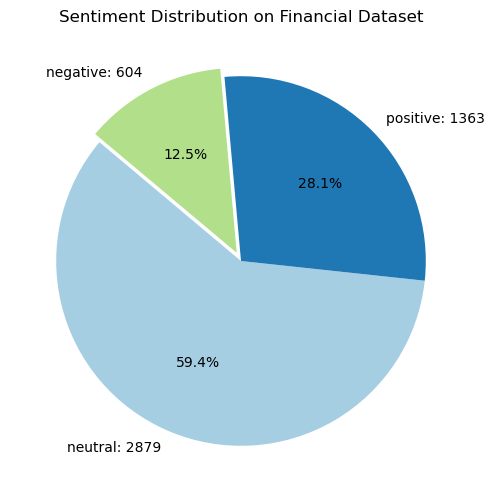

In [130]:
pie_plot()

## Data Preprocessing

In [131]:
# Encode the sentiment labels to integers
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

With the encoder, we have 
- negative = 0, 
- neutral = 1, 
- positive = 2.

In [132]:
data.sample(50)

,sentiment,news,sentiment_encoded
4460,positive,Efore 's results for the last quarter showed a...,2
3023,neutral,Market data and analytics are derived from pri...,1
112,positive,Net sales increased to EUR655m in April to Jun...,2
3578,neutral,ENP Newswire - 22 March 2011 Release date - 21...,1
3448,neutral,"Water Treatment Products In Australia Today , ...",1
3040,neutral,ND = Not disclosed .,1
2379,neutral,"The largest construction company in Finland , ...",1
1597,neutral,Stora Enso Oyj said Friday it will sell its No...,1
1671,neutral,This organization will assume the responsibili...,1
4262,neutral,The machines will cease production by the end ...,1


In [133]:
# Split the data into features (X) and target (y)
X = data['news'].values
y = data['sentiment_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_len=100):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.unk_idx = self.vocab.stoi.get('<unk>', len(self.vocab.stoi))
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokenized = [self.vocab.stoi.get(token, self.unk_idx) for token in self.tokenizer(text)]
        tokenized = [idx if idx < len(self.vocab.stoi) else 0 for idx in tokenized] 

        # # Debugging: Check if any index is out of range
        # if torch.any(tokenized_tensor >= len(self.vocab.stoi)):
        #     print(f"Out-of-range index in text at index {idx}: {text}")
        #     print(f"Tokenized indices: {tokenized_tensor}")
        #     print(f"Vocabulary size: {len(self.vocab.stoi)}")

        return torch.tensor(tokenized, dtype=torch.long), label

In [135]:
# Initialize the GloVe vocabulary and tokenizer
glove = GloVe(name='6B', dim=100)  # 100-dimensional GloVe vectors
tokenizer = get_tokenizer("basic_english")

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, glove, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, glove, tokenizer)

# Define a collate function to pad sequences
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.tensor(labels, dtype=torch.long)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [136]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the last hidden state
        out = self.fc(lstm_out)
        return out

In [137]:
vocab_size = len(glove.stoi)
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Three sentiment classes

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Initialize the embeddings with GloVe vectors
model.embedding.weight.data.copy_(glove.vectors)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [138]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for texts, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')


Epoch 1/100, Loss: 0.9437
Epoch 2/100, Loss: 0.9353
Epoch 3/100, Loss: 0.8811
Epoch 4/100, Loss: 0.7817
Epoch 5/100, Loss: 0.6221
Epoch 6/100, Loss: 0.4927
Epoch 7/100, Loss: 0.4011
Epoch 8/100, Loss: 0.3327
Epoch 9/100, Loss: 0.2602
Epoch 10/100, Loss: 0.1802
Epoch 11/100, Loss: 0.1387
Epoch 12/100, Loss: 0.1096
Epoch 13/100, Loss: 0.1059
Epoch 14/100, Loss: 0.0750
Epoch 15/100, Loss: 0.0610
Epoch 16/100, Loss: 0.0534
Epoch 17/100, Loss: 0.0490
Epoch 18/100, Loss: 0.0386
Epoch 19/100, Loss: 0.0385
Epoch 20/100, Loss: 0.0285
Epoch 21/100, Loss: 0.0255
Epoch 22/100, Loss: 0.0284
Epoch 23/100, Loss: 0.0164
Epoch 24/100, Loss: 0.0151
Epoch 25/100, Loss: 0.0170
Epoch 26/100, Loss: 0.0273
Epoch 27/100, Loss: 0.0189
Epoch 28/100, Loss: 0.0160
Epoch 29/100, Loss: 0.0287
Epoch 30/100, Loss: 0.0128
Epoch 31/100, Loss: 0.0095
Epoch 32/100, Loss: 0.0073
Epoch 33/100, Loss: 0.0077
Epoch 34/100, Loss: 0.0070
Epoch 35/100, Loss: 0.0069
Epoch 36/100, Loss: 0.0046
Epoch 37/100, Loss: 0.0049
Epoch 38/1

In [140]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Assuming you have a test DataLoader named `test_loader`

# 1. Set the model to evaluation mode
model.eval()

# 2. Disable gradient computation as we are not training
with torch.no_grad():
    all_predictions = []
    all_labels = []

    # 3. Iterate over the test data
    for texts, labels in test_loader:
        # Forward pass to get predictions
        outputs = model(texts)
        
        # Get the predicted class by finding the index with the max value
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and labels for metric computation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.7485
Precision: 0.7526
Recall: 0.7485
F1 Score: 0.7492


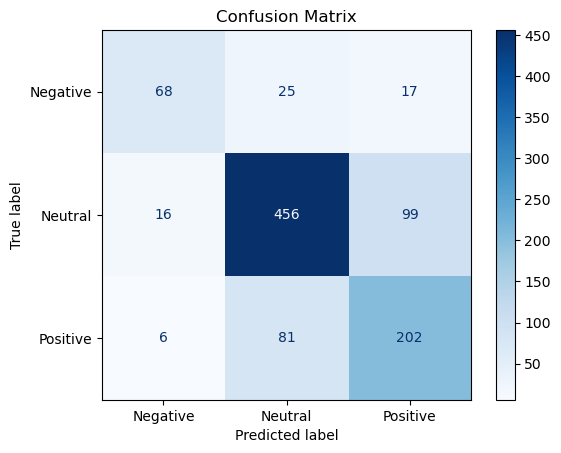

In [141]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have a test DataLoader named `test_loader`
# and the model is already trained and loaded.

# 1. Set the model to evaluation mode
model.eval()

# 2. Disable gradient computation
all_predictions = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        # Forward pass
        outputs = model(texts)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 4. Display the confusion matrix using matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [139]:
# Assuming `model` is your trained model
torch.save(model.state_dict(), './models/lstm/lstm_model.pth')